In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 15.3 시계열 예측하기

* 시계열 : 타임 스텝마다 하나 이상의 값을 가진 시퀀스
* 단변량 시계열 : 타임 스텝마나 하나의 값
* 다변량 시계열 : 타임 스텝마다 여러 값
* 값 대체 : 과거 데이터에서 누락된 값을 예측

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps) ## 수평축 간격 만들기
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)



*   단변랑 시계열 데이터를 가짐
*   [배치 크기, 타임 스텝 수, 1(차원)] 반환



# ▶ np.random.rand(m,n,l)

> 0~1의 균일분포 표준정규분포 난수를 matrix array(m,n,l) 생성

In [4]:
print(np.random.rand(4,10000,1))

[[[0.37454012]
  [0.95071431]
  [0.73199394]
  ...
  [0.94670792]
  [0.39748799]
  [0.2171404 ]]

 [[0.37364082]
  [0.3329121 ]
  [0.17615391]
  ...
  [0.30369847]
  [0.44332001]
  [0.17226481]]

 [[0.72999831]
  [0.184512  ]
  [0.34663969]
  ...
  [0.01945586]
  [0.40100484]
  [0.25739798]]

 [[0.63814457]
  [0.45929245]
  [0.96449852]
  ...
  [0.26956943]
  [0.43431977]
  [0.4874237 ]]]


In [5]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
## X_train은 7000개의 시계열을 담음, 50 steps, 1차원 [7000, 50, 1](0~6999번째 시계열)
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
## 2000개의 시계열(7000~8999번째 시계열)
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
## 1000개의 시계열(9000~9999번째 시계열)

In [6]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


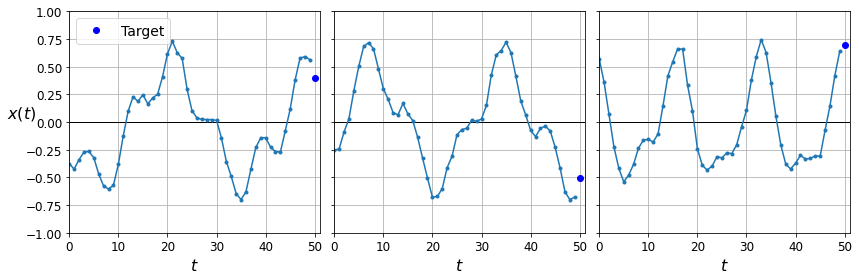

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

# 15.3.1 기준 성능



*   기준 성능의 필요성 : 기본 모델과의 성능 비교


> 1.   순진한 예측
2.   완전 연결 네트워크 사용







### 1. 순진한 예측

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

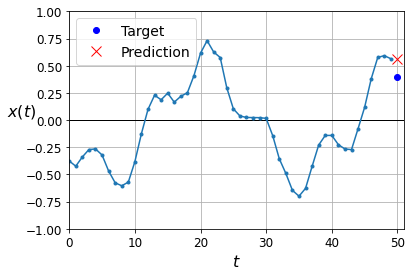

In [9]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### 2. 완전 연결 네트워크 사용

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),## Flatten layer 사용
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 4ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

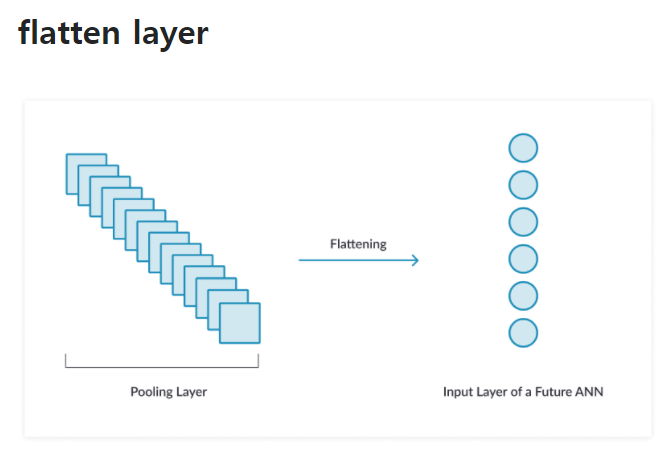

*  flatten layer는 추출된 주요 특징을 전결합층에 전달하기 위해 **1차원 자료**로 바꿔주는 layer
*  이미지 형태의 데이터를 배열형태로 flatten
*  batch size에 영향을 주지 않음

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

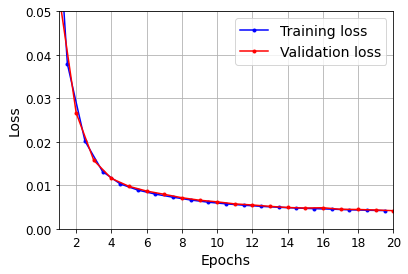

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

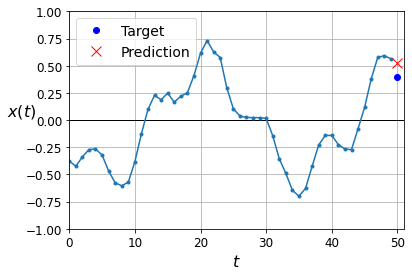

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

> 순진한 예측 그래프

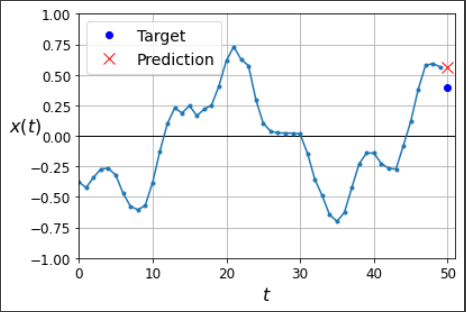

# 15.3.2 간단한 RNN 구현하기

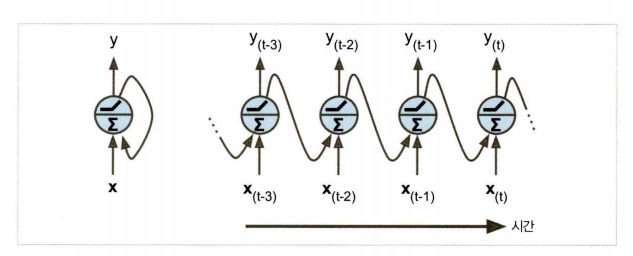

* 하나의 뉴런으로 이루어진 하나의 층을 가짐

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

##가장 간단하게 만들 수 있는 RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
## 순환 신경망은 타임 스텝의 길이와 상관 없이 모두 처리 가능
## 입력 시퀀스의 길이를 지정할 필요가 없다 => None
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 11s 53ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 12s 53ms/step - loss: 0.011

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0109


0.010881561785936356

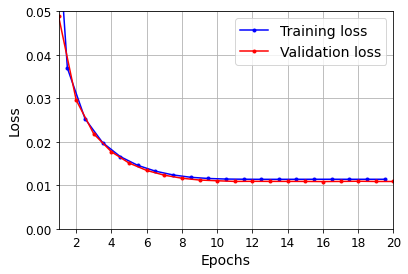

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

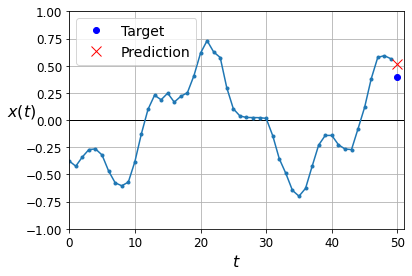

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()



*   순진한 예측보다는 성능이 낫지만 간단한 선형 모델을 앞지르지 못함
*   기본 RNN의 순환 뉴런은 입력과 은닉 상태 차원마다 하나의 파라미터를 가지고 편향이 있음



## 트렌드와 계절성

* 시계열에서 트렌드 삭제 필요 : 매달 10% 성장하는 웹사이트의 접속 사용자 수
* 시계열에서 계절성 삭제 필요 : 여름에 잘 팔리는 선크림 판매량
* 차분 : 매 타임 스텝의 값과 작년도 값의 차이를 계산하여 시계열에서 계절성을 삭제
* RNN을 사용할 때는 이런 작업들이 모두 필요 없음

# 15.3.3 심층 RNN



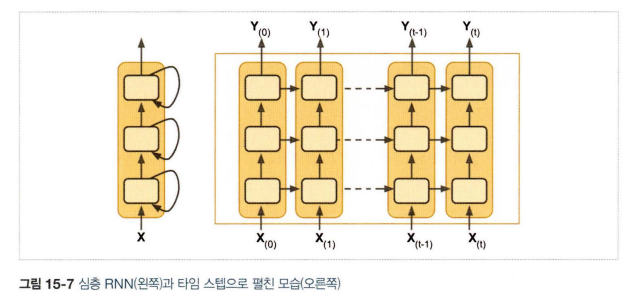

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

## 세 개의 Simple RNN층을 쌓은 것
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
## 마지막 층을 제외하고는 모든 순환 층에서 return_sequences=True로 설정
## 설정 하지 않으면 마지막 타임 스텝의 출력만 담은 2D 배열이 출력되고
## 다음 순환 층이 3D 형태로 시퀀스를 받지 못하기 때문에 작동하지 못함

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 41s 175ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 38s 175ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 37s 171ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 38s 172ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 38s 171ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 37s 170ms/step - l

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 19ms/step - loss: 0.0029


0.002910560928285122

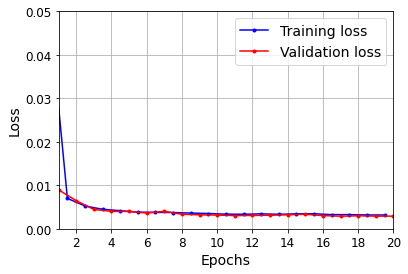

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

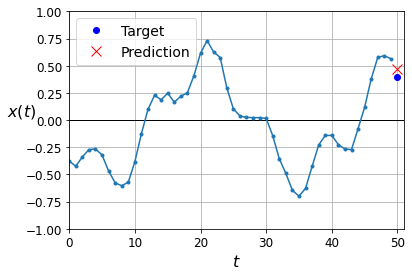

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

* 선형 모델을 앞지르는 성능을 가짐
* 하나의 타임 스텝에서 다음 타임스텝으로 정보를 나르기 위해 다음 순환층의 은닉 상태를 사용 => 마지막 층의 은닉 상태는 크게 필요하지 않음
* SimpleRNN 층은 기본적으로 tanh 활성화 함수를 사용 : 예측된 값이 -1 ~ 1 범위
* 출력층을 Dense 층으로 바꾸면 더 빠르면서 정확도는 거의 비슷, 원하는 활성화 함수 선택 가능
* 출력층 Dense 층으로 바꾸는 방법 : 두 번째 순환층에서 return_sequences=True를 제거

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 27s 115ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 24s 110ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 25s 113ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 25s 113ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 24s 112ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 25s 113ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 24s 112ms/step - l

In [23]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0026


0.0026236234698444605

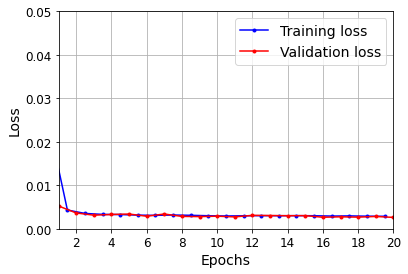

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

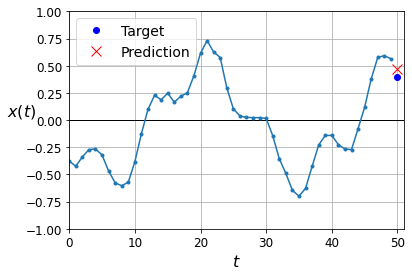

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 15.3.4 여러 타임 스텝 앞을 예측하기



1.   이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하는 방법
2.   RNN을 훈련하여 다음 값 10개를 한 번에 예측하는 방법



In [26]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [27]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


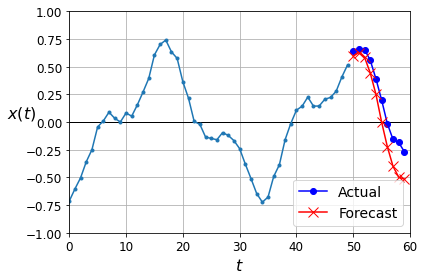

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

다음 10개의 값을 예측하기 위해 9개의 타임 스탭을 더 가진 시퀀스를 다시 생성

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [30]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [31]:
Y_pred.shape

(2000, 10)

In [32]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510803

* 하나씩 다음 10개의 값을 예측

* 다음 스텝에 대한 예측은 다다음 스텝에 대한 예측보다 정확 : 오차가 점점 더 누적되기 때문

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 27s 117ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 25s 116ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 25s 114ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 26s 117ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 25s 115ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 25s 115ms/step - l

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

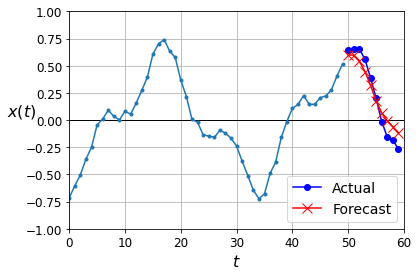

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

* 동시에 다음 10개의 값을 모두 예측하는 RNN

* 장점 : 모든 타임 스텝에서 RNN 출력에 대한 항이 손실에 포함 됨 => 더 많은 오차 그레이디언트가 모델로 흐름. 시간에 따라서만 흐를 필요가 없음.
* 훈련이 안정적, 훈련 속도가 높아짐